In [ ]:
  !unzip '/content/drive/My Drive/classification/archive.zip'
!unzip '/content/drive/My Drive/classification/redemption.zip'

Streaming output truncated to the last 5000 lines.
  inflating: redemtion/train/fp/fp_2830.jpg  
  inflating: redemtion/train/fp/fp_2831.jpg  
  inflating: redemtion/train/fp/fp_2832.jpg  
  inflating: redemtion/train/fp/fp_2833.jpg  
  inflating: redemtion/train/fp/fp_2834.jpg  
  inflating: redemtion/train/fp/fp_2835.jpg  
  inflating: redemtion/train/fp/fp_2836.jpg  
  inflating: redemtion/train/fp/fp_2837.jpg  
  inflating: redemtion/train/fp/fp_2838.jpg  
  inflating: redemtion/train/fp/fp_2839.jpg  
  inflating: redemtion/train/fp/fp_284.jpg  
  inflating: redemtion/train/fp/fp_2840.jpg  
  inflating: redemtion/train/fp/fp_2841.jpg  
  inflating: redemtion/train/fp/fp_2842.jpg  
  inflating: redemtion/train/fp/fp_2843.jpg  
  inflating: redemtion/train/fp/fp_2844.jpg  
  inflating: redemtion/train/fp/fp_2845.jpg  
  inflating: redemtion/train/fp/fp_2846.jpg  
  inflating: redemtion/train/fp/fp_2847.jpg  
  inflating: redemtion/train/fp/fp_2848.jpg  
  inflating: redemtion/train/f

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
DATA_DIR = '/content/cell_images/cell_images/'
SIZE = 64
dataset = []
label = []

In [ ]:
parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((65, 65))
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

In [ ]:
uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((65, 65))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

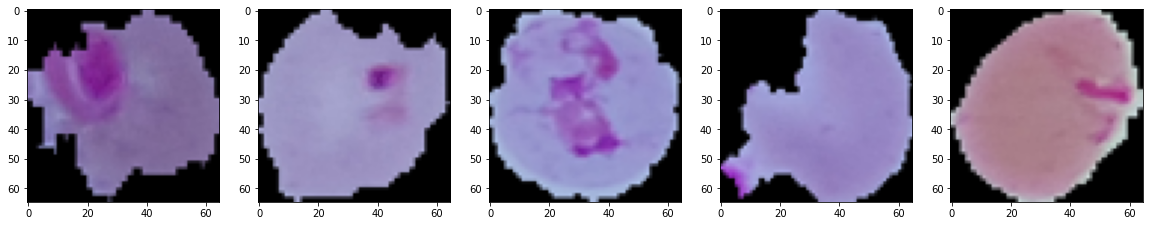

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[image_index])

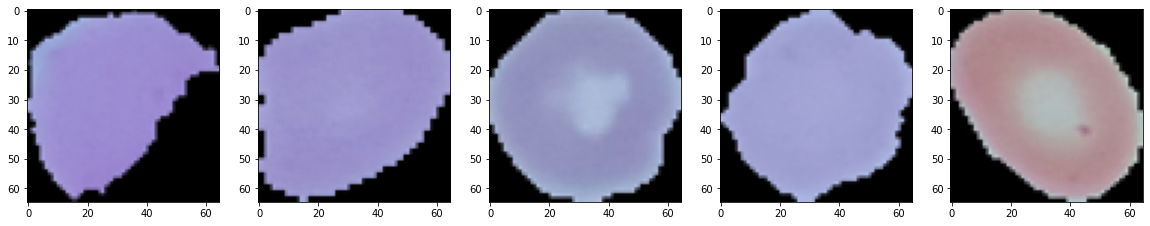

In [ ]:
plt.figure(figsize = (20, 12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images), size = 5)):
    plt.subplot(1, 5, index+1)
    plt.imshow(dataset[len(parasitized_images) + image_index])

In [ ]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state=1000)

In [ ]:
X_val = []
y_val = []

for i in range(len(X_train[17637:])):
    X_val.append(X_train[17637+i])
    y_val.append(y_train[17637+i])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generators = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

val_generator = train_generator.flow(np.array(X_val),
                                       y_val,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

In [ ]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential

In [ ]:
classifier = Sequential()

classifier.add(Convolution2D(32, (3, 3), input_shape = (65, 65, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Convolution2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))

classifier.add(Dropout(0.2))

classifier.add(Dense(activation = 'sigmoid', units=2))


In [ ]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = classifier.fit_generator(train_generators,
                                   steps_per_epoch = len(X_train)/64,
                                   epochs = 50,
                                   shuffle = False,
                                   validation_data=val_generator,
                                   callbacks=[
                                   EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/50
345/344 [==============================] - 31s 90ms/step - loss: 0.4908 - accuracy: 0.7661 - val_loss: 3.3583 - val_accuracy: 0.5010
Epoch 2/50
345/344 [==============================] - 29s 84ms/step - loss: 0.2485 - accuracy: 0.9096 - val_loss: 0.3139 - val_accuracy: 0.8941
Epoch 3/50
345/344 [==============================] - 29s 85ms/step - loss: 0.2148 - accuracy: 0.9249 - val_loss: 0.1562 - val_accuracy: 0.9236
Epoch 4/50
345/344 [==============================] - 29s 84ms/step - loss: 0.1965 - accuracy: 0.9318 - val_loss: 0.1466 - val_accuracy: 0.9397
Epoch 5/50
345/344 [==============================] - 29s 83ms/step - loss: 0.1865 - accuracy: 0.9360 - val_loss: 0.2198 - val_accuracy: 0.9406
Epoch 6/50
345/344 [==============================] - 29s 84ms/step - loss: 0.1843 - accuracy: 0.9375 - val_loss: 0.1669 - val_accuracy: 0.9379
Epoch 7/50
345/344 [==============================] - 29s 84ms/step - loss: 0.1795 - accuracy: 0.9374 - val_loss: 0.1782 - val_accuracy:

In [ ]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(X_test), verbose = 1)[1]*100))

5512/5512 [==============================] - 36s 7ms/step
Test_Accuracy(after augmentation): 95.76%


In [ ]:
classifier.save('malaria_weights.h5')

In [ ]:
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 32)       

In [ ]:
# updating the weights for the new data 

In [ ]:
import os
import cv2
import numpy as np

tp = 0
fp = 0
    
X_train = []
y_train = []
    
path = r'/content/redemtion/train/tp'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_train.append(pic)
        y_train.append(1)
        tp += 1
            
path = r'/content/redemtion/train/fp'
    
for image in os.listdir(path):
        # print(image)
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_train.append(pic)
        y_train.append(0)
        fp += 1

path = r'/content/redemtion/val/fp'
    
for image in os.listdir(path):
        # print(image)
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_train.append(pic)
        y_train.append(0)
        fp += 1

print('train tp',tp)
print('train fp',fp)


tp = 0
fp = 0
X_test = []
y_test = []
    
path = r'/content/redemtion/test/tp'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_test.append(pic)
        y_test.append(1)
        tp += 1
            
path = r'/content/redemtion/test/fp'
    
for image in os.listdir(path):
    pic = cv2.imread(path+'/'+image)
    if np.shape(pic) != (65,65,3):
        pic = cv2.resize(pic, (65,65))
        X_test.append(pic)
        y_test.append(0)
        fp += 1


print('test tp',tp)
print('test fp',fp)




train tp 2053
train fp 4218
test tp 286
test fp 469


In [ ]:
from keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(X_train, to_categorical(np.array(y_train)), test_size = 0.10, random_state=1000)

In [ ]:
from keras.utils import to_categorical

X_tests, _, y_tests, _ = train_test_split(X_test, to_categorical(np.array(y_test)), test_size = 0.00000010)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)


train_generators = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 20,
                                       shuffle = False)

val_generator = train_generator.flow(np.array(X_val),
                                       y_val,
                                       batch_size = 20,
                                       shuffle = False)


test_generator = ImageDataGenerator(rescale = 1/255)

test_generator = test_generator.flow(np.array(X_tests),
                                     y_tests,
                                     batch_size = 20,
                                     shuffle = False)

In [ ]:
from keras.models import load_model

classifier = load_model('/content/malaria_weights.h5')

In [ ]:
for layer in classifier.layers[:5]:
    print(layer.name)
    layer.trainable = False

conv2d_13
max_pooling2d_13
batch_normalization_19
dropout_19
conv2d_14


In [ ]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 32)       

In [ ]:
classifier.save('motisis_model1.h5')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier.fit_generator(train_generators,
                          steps_per_epoch = len(X_train)/20,
                          epochs = 50,
                          shuffle = False,
                          validation_data= val_generator,
                          callbacks=[
                              EarlyStopping(patience=10,restore_best_weights=True)]
                         )

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50
283/282 [==============================] - 9s 33ms/step - loss: 0.4316 - accuracy: 0.7935 - val_loss: 0.0564 - val_accuracy: 0.8631
Epoch 2/50
283/282 [==============================] - 9s 30ms/step - loss: 0.2856 - accuracy: 0.8781 - val_loss: 1.9438 - val_accuracy: 0.6401
Epoch 3/50
283/282 [==============================] - 9s 30ms/step - loss: 0.2409 - accuracy: 0.8944 - val_loss: 1.4958 - val_accuracy: 0.6449
Epoch 4/50
283/282 [==============================] - 9s 31ms/step - loss: 0.2253 - accuracy: 0.9073 - val_loss: 2.1953 - val_accuracy: 0.6401
Epoch 5/50
283/282 [==============================] - 8s 30ms/step - loss: 0.2061 - accuracy: 0.9144 - val_loss: 0.0796 - val_accuracy: 0.9108
Epoch 6/50
283/282 [==============================] - 8s 29ms/step - loss: 0.2134 - accuracy: 0.9128 - val_loss: 0.3561 - val_accuracy: 0.7325
Epoch 7/50
283/282 [==============================] - 8s 29ms/step - loss: 0.1960 - accuracy: 0.9201 - val_loss: 0.2754 - val_accuracy: 0.7564

In [ ]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate_generator(test_generator, steps = len(y_tests), verbose = 1)[1]*100))                                    

754/754 [==============================] - 4s 6ms/step
Test_Accuracy(after augmentation): 82.82%


In [ ]:
from keras.models import load_model

classifier = load_model('/content/motisis_model1.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
predictions = classifier.predict(test_generator)

In [ ]:
'''
Calculate F-score
'''

count = 0
total = 0
correct = 0

tp= 0
fp=0
fn=0
tn=0


for i in range(len(y_tests)):

    if predictions[i][0] < predictions[i][1] and y_tests[i][0] == 1.:
        fp += 1
    elif predictions[i][0] < predictions[i][1] and y_tests[i][0] == 0.:
        # fp
        tp += 1
        correct += 1

    total += 1

print(tp)
print(fp)
print(total)
Precision = tp/(tp+fp)
Recall = tp/(286)

f_score = (2 * Precision * Recall) / (Precision + Recall)


print(Precision)
print(Recall)
print(f_score)

244
88
754
0.7349397590361446
0.8531468531468531
0.7896440129449838
